In [23]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
dados = pd.read_csv('/content/drive/MyDrive/microsoft-data/Microsoft_Stock.csv')

print(dados.head())

                Date   Open   High    Low  Close    Volume
0  4/1/2015 16:00:00  40.60  40.76  40.31  40.72  36865322
1  4/2/2015 16:00:00  40.66  40.74  40.12  40.29  37487476
2  4/6/2015 16:00:00  40.34  41.78  40.18  41.55  39223692
3  4/7/2015 16:00:00  41.61  41.91  41.31  41.53  28809375
4  4/8/2015 16:00:00  41.48  41.69  41.04  41.42  24753438


In [13]:
dados['ds'] = pd.to_datetime(dados['Date'])
dados['y'] = dados['Close']

dados_prophet = dados[['ds', 'y']]

In [14]:
train_size = int(len(dados_prophet) * 0.8)
dados_treino_prophet = dados_prophet[:train_size]
dados_teste_prophet = dados_prophet[train_size:]

In [15]:
modelo_prophet = Prophet()
modelo_prophet.fit(dados_treino_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp55jw_xij/7c6hfr4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55jw_xij/8ygwpgyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21098', 'data', 'file=/tmp/tmp55jw_xij/7c6hfr4j.json', 'init=/tmp/tmp55jw_xij/8ygwpgyv.json', 'output', 'file=/tmp/tmp55jw_xij/prophet_model1u82juhs/prophet_model-20241003164824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
future_prophet = dados_teste_prophet[['ds']]
previsoes_prophet = modelo_prophet.predict(future_prophet)

mae_prophet = mean_absolute_error(dados_teste_prophet['y'].values, previsoes_prophet['yhat'].values)

print(f'MAE do Prophet: {mae_prophet}')

MAE do Prophet: 10.363244037450011


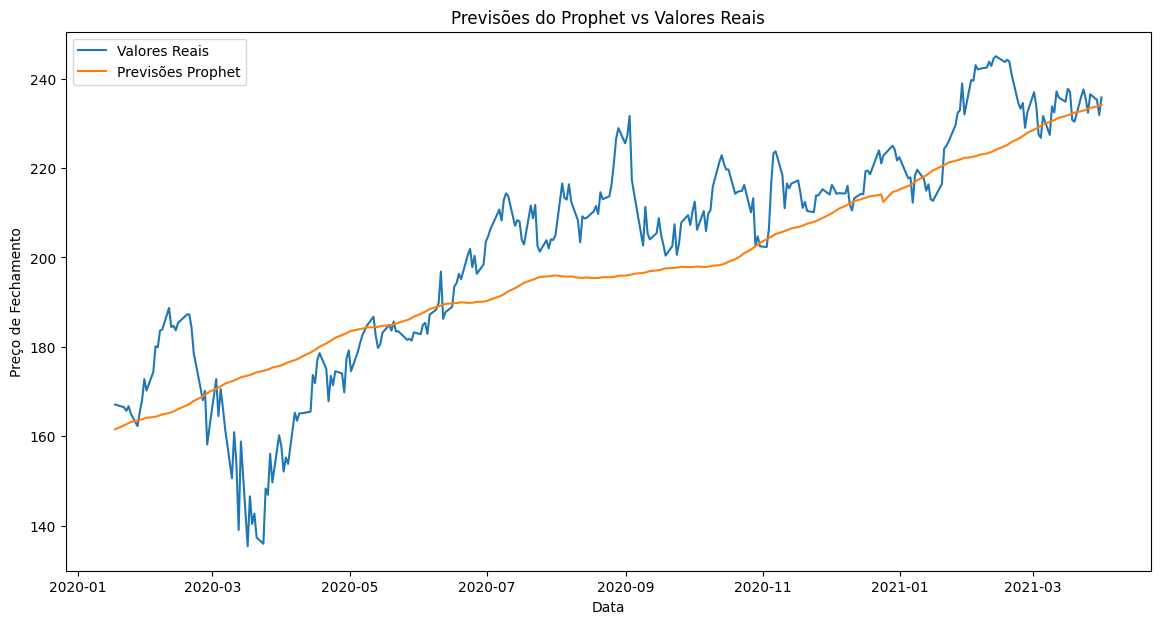

In [24]:
plt.figure(figsize=(14,7))
plt.plot(dados_teste_prophet['ds'], dados_teste_prophet['y'], label='Valores Reais')
plt.plot(previsoes_prophet['ds'], previsoes_prophet['yhat'], label='Previsões Prophet')
plt.title('Previsões do Prophet vs Valores Reais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [16]:
future = modelo_prophet.make_future_dataframe(periods=len(dados_teste_prophet))

forecast = modelo_prophet.predict(future)

previsoes_prophet = forecast[['ds', 'yhat']].iloc[-len(dados_teste_prophet):].reset_index(drop=True)

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
dados['y_scaled'] = scaler.fit_transform(dados[['y']])

In [18]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60

dados_treino_lstm = dados['y_scaled'].values[:train_size]
dados_teste_lstm = dados['y_scaled'].values[train_size - seq_length:]

X_train, y_train = create_sequences(dados_treino_lstm, seq_length)
X_test, y_test = create_sequences(dados_teste_lstm, seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0295
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.9121e-04
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.2517e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.4139e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 1.2472e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.3599e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.2253e-04
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.2485e-04
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.4578e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.4464e-04


In [25]:
previsoes_lstm_scaled = model.predict(X_test)

previsoes_lstm = scaler.inverse_transform(previsoes_lstm_scaled)

y_test_descaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae_lstm = mean_absolute_error(y_test_descaled, previsoes_lstm)

print(f'MAE do LSTM: {mae_lstm}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE do LSTM: 7.280786604173114


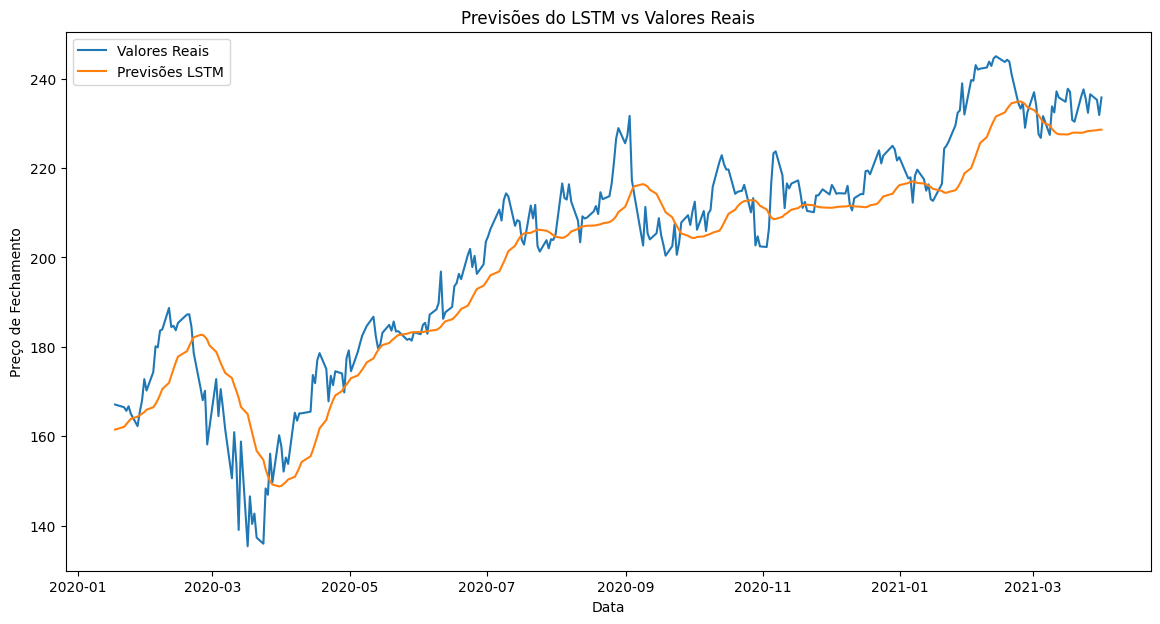

In [27]:
datas_teste_lstm = dados['ds'][-len(y_test_descaled):].reset_index(drop=True)

y_test_descaled_flat = y_test_descaled.flatten()
previsoes_lstm_flat = previsoes_lstm.flatten()

plt.figure(figsize=(14,7))
plt.plot(datas_teste_lstm, y_test_descaled_flat, label='Valores Reais')
plt.plot(datas_teste_lstm, previsoes_lstm_flat, label='Previsões LSTM')
plt.title('Previsões do LSTM vs Valores Reais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [28]:
print(f'MAE do Prophet: {mae_prophet}')
print(f'MAE do LSTM: {mae_lstm}')

MAE do Prophet: 10.363244037450011
MAE do LSTM: 7.280786604173114


A métrica MAE foi escolhida para avaliar o desempenho dos modelos porque é uma medida intuitiva e facilmente interpretável da precisão das previsões. O MAE calcula a média das diferenças absolutas entre as previsões e os valores reais, fornecendo uma indicação clara do erro médio sem dar peso adicional a grandes erros, ao contrário do MSE.

Segundo **Hyndman e Koehler (2006)**, o MAE é menos sensível a outliers e é apropriado quando todos os erros são igualmente importantes. Isso o torna especialmente útil em séries temporais financeiras, como os preços de ações, onde outliers podem distorcer significativamente outras métricas.

**Referência:**

Hyndman, R. J., & Koehler, A. B. (2006). *Another look at measures of forecast accuracy*. International Journal of Forecasting, 22(4), 679-688.
